In [48]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import func
from scipy import stats
from matplotlib.dates import DateFormatter

In [49]:
import numpy as np
import pandas as pd

In [50]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [51]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.orm import Session

In [52]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [53]:
# reflect an existing database into a new model
Base = automap_base()
 
# reflect the tables
Base.prepare(engine, reflect=True)

In [54]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [55]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [56]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

* Analysis of last 12 months of precipitation data indicates no positive correlation of seasonal impact on precipitation.

## Design a query to retrieve the last 12 months of precipitation data and plot the results

### Calculate the date 1 year ago from the last data point in the database

In [57]:
for row in session.query(Measurement).order_by(Measurement.date.desc()).limit(1):
    max_date = dt.datetime.strptime(row.date,'%Y-%m-%d')

year_before_max_date = max_date - dt.timedelta(12*366/12)

### Perform a query to retrieve the data and precipitation scores

In [58]:
query = (session
         .query(Measurement.date, Measurement.prcp)
         .filter(Measurement.date > year_before_max_date))

last_12_months_precipitation_df = pd.read_sql_query(query.statement, session.get_bind())

### Save the query results as a Pandas DataFrame and set the index to the date column

In [59]:
last_12_months_precipitation_df = last_12_months_precipitation_df.dropna()
last_12_months_precipitation_df = last_12_months_precipitation_df.set_index('date', drop=False)

### Sort the dataframe by date

In [60]:
last_12_months_precipitation_df = last_12_months_precipitation_df.sort_index()
last_12_months_precipitation_df = last_12_months_precipitation_df.rename(columns={"date": "Date", "prcp": "Precipitation"})

## Use Pandas Plotting with Matplotlib to plot the data

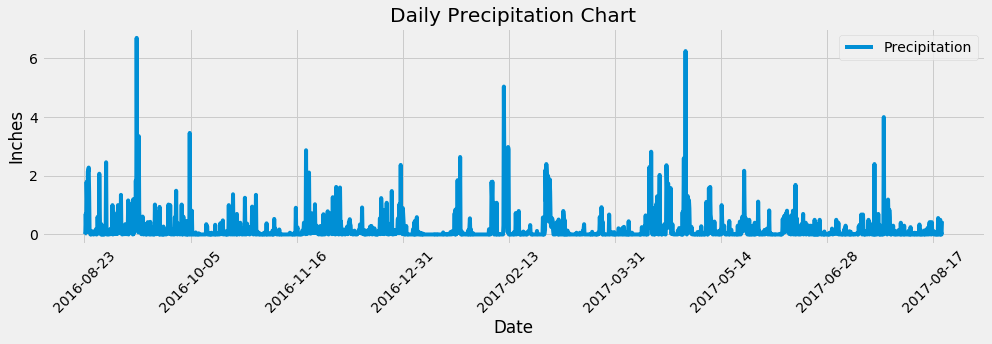

In [61]:
last_12_months_precipitation_df.plot(x="Date",y="Precipitation",title="Daily Precipitation Chart",figsize=(14, 5))
plt.xticks(rotation=45)
plt.ylabel("Inches")
plt.tight_layout()

In [65]:
# Use Pandas to calcualte the summary statistics for the precipitation data

measurement = (session.query(Measurement))

measurement_df = pd.read_sql_query(measurement.statement, session.get_bind())

measurement_df['prcp'].describe()

count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: prcp, dtype: float64

## Station Analysis

* Highest temperature observations were recorded for station USC00519281(2772). USC00519281 measured average temperature 71.66 degrees. Highest and lowest temperatures observed were 85 degrees and 54 degrees respectively. 

In [17]:
# Design a query to show how many stations are available in this dataset?
available_stations = (session
         .query(Station.station)
         .distinct().count())

print(f"Number of available stations are {available_stations}")

Number of available stations are 9


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = (session
                   .query(Measurement.station,func.count(Measurement.station).label('Count'))
                  .group_by(Measurement.station)
                  .order_by('Count DESC'))

active_stations_df = pd.read_sql_query(active_stations.statement, session.get_bind())

active_stations_df.head()

/Users/prerakpatel/miniconda3/lib/python3.7/site-packages/sqlalchemy/sql/compiler.py:763: SAWarning: Can't resolve label reference 'Count DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element),


,station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [34]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

measurement_agg = (session
                   .query(Measurement.station,func.max(Measurement.tobs).label('Highest Temp'),func.avg(Measurement.tobs).label('Average Temp'),func.min(Measurement.tobs).label('Lowest Temp'))
                  .filter(Measurement.station == "USC00519281"))

measurement_agg_df = pd.read_sql_query(measurement_agg.statement, session.get_bind())
measurement_agg_df.head()

,station,Highest Temp,Average Temp,Lowest Temp
0,USC00519281,85.0,71.663781,54.0


In [77]:
# Choose/Filter by the station with the highest number of observations.
max_date = (session
            .query(func.max(Measurement.date)
            .label('Max Date'))
            .filter(Measurement.station == "USC00519281"))

for row in session.query(func.max(Measurement.date).label('Max_Date')).filter(Measurement.station == "USC00519281"):
    max_date = dt.datetime.strptime(row.Max_Date,'%Y-%m-%d')

year_before_max_date = max_date - dt.timedelta(12*366/12)

2016-08-17 00:00:00
2017-08-18 00:00:00


### Query the last 12 months of temperature observation data for station with highest number of tobs

In [78]:
highest_temp_observation_station = (session
         .query(Measurement.tobs)
         .filter(Measurement.date > year_before_max_date)
         .filter(Measurement.station == "USC00519281"))

last_12_months_tobs_df = pd.read_sql_query(highest_temp_observation_station.statement, session.get_bind())
last_12_months_tobs_df.head(15)

357

### Plot the results as a histogram with bins=12

Text(0.5, 1.0, 'Most Active Station - Temperature VS Frequency ')

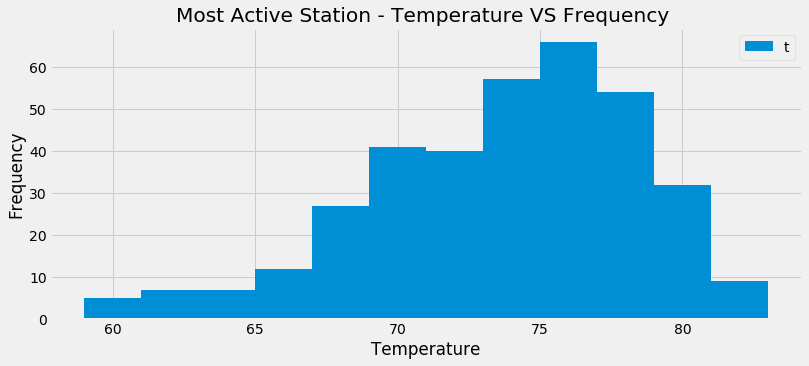

In [91]:

last_12_months_tobs_df.hist(column='tobs', bins=12,figsize=(12, 5))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend("tobs", loc='upper right')
plt.title("Most Active Station - Temperature VS Frequency ")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [128]:
from sqlalchemy import and_
date = "2017-01-18"
start_date = dt.datetime.strptime(date,'%Y-%m-%d')

# testss = (session
#                 .query(Measurement.tobs)
#                 .filter(Measurement.date == start_date)
#             ).statement

print((session
            .query(Measurement.tobs)
                .filter(Measurement.date >= start_date)
                .filter(Measurement.date <= start_date)
            ).statement)
# for row in testss:
#     print(row.tobs)

SELECT measurement.tobs 
FROM measurement 
WHERE measurement.date >= :date_1 AND measurement.date <= :date_2


In [113]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
